# Sentimental Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

plt.style.use('ggplot')

import nltk

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [ ]:
df = df.drop(['ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time'],axis=1)
df.head()

,Id,Score,Summary,Text
0,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,2,Cough Medicine,If you are looking for the secret ingredient i...
4,5,5,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
df.shape

(568454, 4)

In [ ]:
df.Score.value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

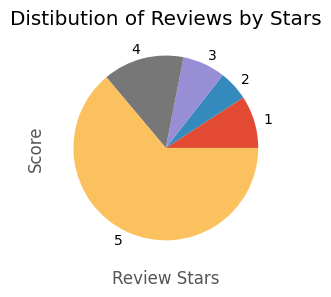

In [ ]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='pie',
          title='Distibution of Reviews by Stars',
          figsize=(5, 3))
ax.set_xlabel('Review Stars')
plt.show()

In [ ]:
target_count = 500

dataset = []

for score in df['Score'].unique():
    sampled_rows = df[df['Score'] == score].sample(target_count, random_state=40)
    dataset.append(sampled_rows)

dataset = pd.concat(dataset)

dataset = dataset.reset_index(drop=True)

In [ ]:
dataset.shape

(2500, 4)

In [ ]:
dataset.head()

,Id,Score,Summary,Text
0,156825,5,Good Stuff. Fair Price,"If you're a Crystal Light fan, this will not d..."
1,353928,5,I love this Quinoa. Cooks up well in a rice co...,This has quickly become a staple in our home! ...
2,447975,5,Everyone said GREAT!,Unfortunately I never had a chance to try thes...
3,447676,5,Pregnant 1 month after drinking,I drank this tea 3-4 cups everyday and the nex...
4,112409,5,Yum,"Bought these for my girlfriend, she loves them..."


In [ ]:
dataset.Score.value_counts()

5    500
1    500
4    500
2    500
3    500
Name: Score, dtype: int64

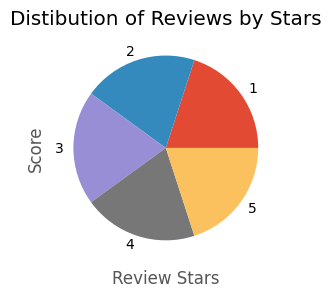

In [ ]:
ax = dataset['Score'].value_counts().sort_index() \
    .plot(kind='pie',
          title='Distibution of Reviews by Stars',
          figsize=(5, 3))
ax.set_xlabel('Review Stars')
plt.show()

# NLP Process

In [ ]:
example = dataset.Text[69]
example

'We have added coconut oil to our diet, and my husband prefers the capsules to eating it on his food.  This works for us.'

In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm')

In [ ]:
def remove_spaces(text):
  text = re.sub(r'<br \/><br \/>', '', text)
  text = re.sub(r'\n', '', text)
  text = re.sub(r'\s+', ' ', text).strip()
  return text

In [ ]:
def preprocessing(text):
  doc = nlp(text)
  filtered= []

  for token in doc:
    if token.is_punct:
      continue
    filtered.append(token.text)

  combine = " ".join(filtered)
  combine_lower = combine.lower()
  result = remove_spaces(combine_lower)

  return result

In [ ]:
preprocessing(example)

'we have added coconut oil to our diet and my husband prefers the capsules to eating it on his food this works for us'

In [ ]:
dataset['Preprocessed_Text'] = dataset['Text'].apply(preprocessing)

In [ ]:
dataset.head()

,Id,Score,Summary,Text,Preprocessed_Text
0,156825,5,Good Stuff. Fair Price,"If you're a Crystal Light fan, this will not d...",if you 're a crystal light fan this will not d...
1,353928,5,I love this Quinoa. Cooks up well in a rice co...,This has quickly become a staple in our home! ...,this has quickly become a staple in our home i...
2,447975,5,Everyone said GREAT!,Unfortunately I never had a chance to try thes...,unfortunately i never had a chance to try thes...
3,447676,5,Pregnant 1 month after drinking,I drank this tea 3-4 cups everyday and the nex...,i drank this tea 3 4 cups everyday and the nex...
4,112409,5,Yum,"Bought these for my girlfriend, she loves them...",bought these for my girlfriend she loves them ...


In [ ]:
len(dataset)

2500

# VADER

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [ ]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [ ]:
example = dataset.Preprocessed_Text[89]

In [ ]:
example

'my two chihuahuas absolutely love these treats they get one at bedtime and follow me around until i give it to them these are great healthy moist treats for a good price would highly recommend'

In [ ]:
sia.polarity_scores(preprocessing(example))

{'neg': 0.0, 'neu': 0.622, 'pos': 0.378, 'compound': 0.9516}

In [ ]:
dataset[dataset['Score'] == 1]

,Id,Score,Summary,Text,Preprocessed_Text
500,178448,1,Are you kidding me?,This is a ridiculous price for some soup in a ...,this is a ridiculous price for some soup in a ...
501,227513,1,Slimmy,I had great hopes for these noodles. I prepare...,i had great hopes for these noodles i prepared...
502,197257,1,Do Not Purchase,Dixie Carb Counters Dine 'n Dash Cream of Mush...,dixie carb counters dine n dash cream of mushr...
503,553067,1,Pasty,I was so looking forward to these..finally a s...,i was so looking forward to these finally a su...
504,341700,1,THE WORST I HAVE EVER HAD,I love chips...and have been noshing on the re...,i love chips and have been noshing on the regu...
...,...,...,...,...,...
995,174004,1,Made both my dogs vomit and eat less.,We switched to this food from Purina One becau...,we switched to this food from purina one becau...
996,525435,1,Worst Shipping EVER,"I love Weruva for my dogs, let me say that up ...",i love weruva for my dogs let me say that up f...
997,452630,1,Rice and Oatmeal Cereals - Toxic Hexane,The can of oatmeal clearly says they use Life'...,the can of oatmeal clearly says they use life ...
998,24967,1,Strange Aftertaste-not at all like Creme Brulee,I have enjoyed creme brulee on many occasions ...,i have enjoyed creme brulee on many occasions ...


In [ ]:
dataset.Text[502]

"Dixie Carb Counters Dine 'n Dash Cream of Mushroom Soup Mix is not a cream of mushroom soup at all. It's vey watery and the taste isn't good at all. I do not recommend this product for low carb dieters."

In [ ]:
dataset.Preprocessed_Text[502]

"dixie carb counters dine n dash cream of mushroom soup mix is not a cream of mushroom soup at all it 's vey watery and the taste is n't good at all i do not recommend this product for low carb dieters"

In [ ]:
sia.polarity_scores(dataset.Text[502])

{'neg': 0.159, 'neu': 0.841, 'pos': 0.0, 'compound': -0.6824}

In [ ]:
sia.polarity_scores(dataset.Preprocessed_Text[502])

{'neg': 0.155, 'neu': 0.845, 'pos': 0.0, 'compound': -0.6824}

In [ ]:
dataset.head()

,Id,Score,Summary,Text,Preprocessed_Text
0,156825,5,Good Stuff. Fair Price,"If you're a Crystal Light fan, this will not d...",if you 're a crystal light fan this will not d...
1,353928,5,I love this Quinoa. Cooks up well in a rice co...,This has quickly become a staple in our home! ...,this has quickly become a staple in our home i...
2,447975,5,Everyone said GREAT!,Unfortunately I never had a chance to try thes...,unfortunately i never had a chance to try thes...
3,447676,5,Pregnant 1 month after drinking,I drank this tea 3-4 cups everyday and the nex...,i drank this tea 3 4 cups everyday and the nex...
4,112409,5,Yum,"Bought these for my girlfriend, she loves them...",bought these for my girlfriend she loves them ...


In [ ]:
len(dataset.Id.value_counts())

2500

In [ ]:
dataset.index

RangeIndex(start=0, stop=2500, step=1)

In [ ]:
res = {}
for i, row in tqdm(dataset.iterrows(), total=len(dataset)):
    text = row['Preprocessed_Text']
    res[i] = sia.polarity_scores(text)

  0%|          | 0/2500 [00:00<?, ?it/s]

In [ ]:
vaders = pd.DataFrame(res).T

In [ ]:
vaders.shape

(2500, 4)

In [ ]:
vaders

,neg,neu,pos,compound
0,0.000,0.533,0.467,0.9187
1,0.013,0.847,0.140,0.9910
2,0.121,0.759,0.120,0.2406
3,0.000,0.896,0.104,0.5065
4,0.068,0.697,0.235,0.9423
...,...,...,...,...
2495,0.013,0.876,0.111,0.9413
2496,0.044,0.902,0.053,0.0802
2497,0.000,0.821,0.179,0.7269
2498,0.102,0.563,0.335,0.8648


In [ ]:
dataset

,Id,Score,Summary,Text,Preprocessed_Text
0,156825,5,Good Stuff. Fair Price,"If you're a Crystal Light fan, this will not d...",if you 're a crystal light fan this will not d...
1,353928,5,I love this Quinoa. Cooks up well in a rice co...,This has quickly become a staple in our home! ...,this has quickly become a staple in our home i...
2,447975,5,Everyone said GREAT!,Unfortunately I never had a chance to try thes...,unfortunately i never had a chance to try thes...
3,447676,5,Pregnant 1 month after drinking,I drank this tea 3-4 cups everyday and the nex...,i drank this tea 3 4 cups everyday and the nex...
4,112409,5,Yum,"Bought these for my girlfriend, she loves them...",bought these for my girlfriend she loves them ...
...,...,...,...,...,...
2495,48428,3,Not a favorite...,"Okay, I like banana bread and my family will e...",okay i like banana bread and my family will ea...
2496,357938,3,Packaging Problem,"While the food is good quality, it doesn't alw...",while the food is good quality it does n't alw...
2497,223542,3,The crisps are just crumbs!,"Good flavor, but I expected ""wafers"" that I co...",good flavor but i expected wafers that i could...
2498,345983,3,"Ok, but not great",I gave these a try for the great price. Unfor...,i gave these a try for the great price unfortu...


In [ ]:
dataset.shape, vaders.shape

((2500, 5), (2500, 4))

In [ ]:
vaders['key'] = range(len(vaders))

In [ ]:
dataset['key'] = range(len(dataset))

In [ ]:
merged_data = pd.merge(vaders, dataset, on='key')

In [ ]:
merged_data.head()

,neg,neu,pos,compound,key,Id,Score,Summary,Text,Preprocessed_Text
0,0.000,0.533,0.467,0.9187,0,156825,5,Good Stuff. Fair Price,"If you're a Crystal Light fan, this will not d...",if you 're a crystal light fan this will not d...
1,0.013,0.847,0.140,0.9910,1,353928,5,I love this Quinoa. Cooks up well in a rice co...,This has quickly become a staple in our home! ...,this has quickly become a staple in our home i...
2,0.121,0.759,0.120,0.2406,2,447975,5,Everyone said GREAT!,Unfortunately I never had a chance to try thes...,unfortunately i never had a chance to try thes...
3,0.000,0.896,0.104,0.5065,3,447676,5,Pregnant 1 month after drinking,I drank this tea 3-4 cups everyday and the nex...,i drank this tea 3 4 cups everyday and the nex...
4,0.068,0.697,0.235,0.9423,4,112409,5,Yum,"Bought these for my girlfriend, she loves them...",bought these for my girlfriend she loves them ...


In [ ]:
vaders = merged_data.drop('key',axis=1)

In [ ]:
vaders

,neg,neu,pos,compound,Id,Score,Summary,Text,Preprocessed_Text
0,0.000,0.533,0.467,0.9187,156825,5,Good Stuff. Fair Price,"If you're a Crystal Light fan, this will not d...",if you 're a crystal light fan this will not d...
1,0.013,0.847,0.140,0.9910,353928,5,I love this Quinoa. Cooks up well in a rice co...,This has quickly become a staple in our home! ...,this has quickly become a staple in our home i...
2,0.121,0.759,0.120,0.2406,447975,5,Everyone said GREAT!,Unfortunately I never had a chance to try thes...,unfortunately i never had a chance to try thes...
3,0.000,0.896,0.104,0.5065,447676,5,Pregnant 1 month after drinking,I drank this tea 3-4 cups everyday and the nex...,i drank this tea 3 4 cups everyday and the nex...
4,0.068,0.697,0.235,0.9423,112409,5,Yum,"Bought these for my girlfriend, she loves them...",bought these for my girlfriend she loves them ...
...,...,...,...,...,...,...,...,...,...
2495,0.013,0.876,0.111,0.9413,48428,3,Not a favorite...,"Okay, I like banana bread and my family will e...",okay i like banana bread and my family will ea...
2496,0.044,0.902,0.053,0.0802,357938,3,Packaging Problem,"While the food is good quality, it doesn't alw...",while the food is good quality it does n't alw...
2497,0.000,0.821,0.179,0.7269,223542,3,The crisps are just crumbs!,"Good flavor, but I expected ""wafers"" that I co...",good flavor but i expected wafers that i could...
2498,0.102,0.563,0.335,0.8648,345983,3,"Ok, but not great",I gave these a try for the great price. Unfor...,i gave these a try for the great price unfortu...


In [ ]:
vaders.columns

Index(['neg', 'neu', 'pos', 'compound', 'Id', 'Score', 'Summary', 'Text',
       'Preprocessed_Text'],
      dtype='object')

In [ ]:
vaders = vaders.rename(columns={'neg': 'vader_neg', 'neu': 'vader_neu', 'pos': 'vader_pos'})

In [ ]:
vaders.head()

,vader_neg,vader_neu,vader_pos,compound,Id,Score,Summary,Text,Preprocessed_Text
0,0.000,0.533,0.467,0.9187,156825,5,Good Stuff. Fair Price,"If you're a Crystal Light fan, this will not d...",if you 're a crystal light fan this will not d...
1,0.013,0.847,0.140,0.9910,353928,5,I love this Quinoa. Cooks up well in a rice co...,This has quickly become a staple in our home! ...,this has quickly become a staple in our home i...
2,0.121,0.759,0.120,0.2406,447975,5,Everyone said GREAT!,Unfortunately I never had a chance to try thes...,unfortunately i never had a chance to try thes...
3,0.000,0.896,0.104,0.5065,447676,5,Pregnant 1 month after drinking,I drank this tea 3-4 cups everyday and the nex...,i drank this tea 3 4 cups everyday and the nex...
4,0.068,0.697,0.235,0.9423,112409,5,Yum,"Bought these for my girlfriend, she loves them...",bought these for my girlfriend she loves them ...


In [ ]:
ref = vaders[['Preprocessed_Text','Id']]

In [ ]:
ref.head()

,Preprocessed_Text,Id
0,if you 're a crystal light fan this will not d...,156825
1,this has quickly become a staple in our home i...,353928
2,unfortunately i never had a chance to try thes...,447975
3,i drank this tea 3 4 cups everyday and the nex...,447676
4,bought these for my girlfriend she loves them ...,112409


# Plotting VADER results

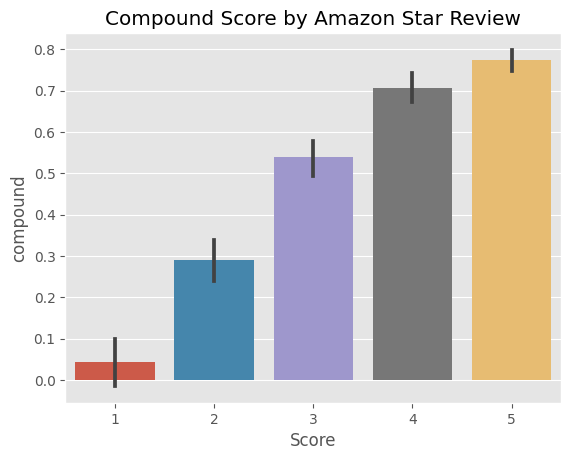

In [ ]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compound Score by Amazon Star Review')
plt.show()

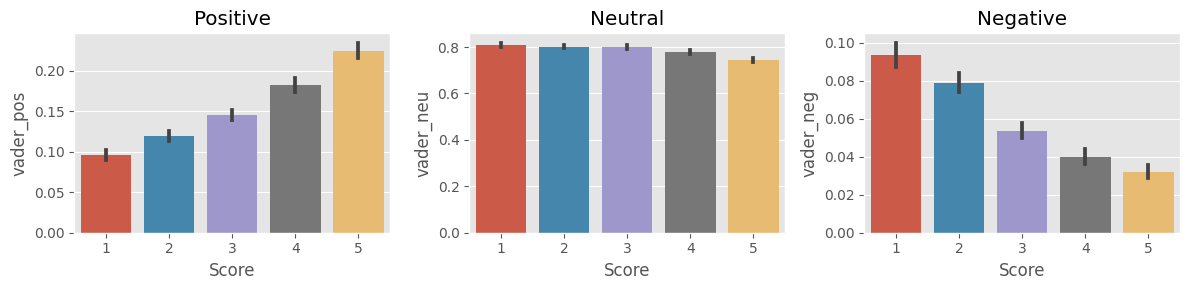

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='vader_pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='vader_neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='vader_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Roberta Pretrained Model

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.0 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
print(example)
sia.polarity_scores(example)

my two chihuahuas absolutely love these treats they get one at bedtime and follow me around until i give it to them these are great healthy moist treats for a good price would highly recommend


{'neg': 0.0, 'neu': 0.622, 'pos': 0.378, 'compound': 0.9516}

In [ ]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0015503844, 'roberta_neu': 0.007859493, 'roberta_pos': 0.9905901}


In [ ]:
ex = vaders.Preprocessed_Text[78]

In [ ]:
ex

"i subscribe to the road 's end gravy packets because they are a great way to make a satisfying backpacking or camping meal i can sautee up some fresh or re hydrated veggies add some gravy and eat them on top of instant mashed potatoes for a rich filling meal the flavor is great you do n't have to use the whole pack just roll down the top and save some for later.these gravy packets also make an excellent binder to replace the ubi you know campbell 's cream of mushroom in dishes like broccoli rice casserole throw in a little daiya cheese"

In [ ]:
print(ex)
sia.polarity_scores(ex)

i subscribe to the road 's end gravy packets because they are a great way to make a satisfying backpacking or camping meal i can sautee up some fresh or re hydrated veggies add some gravy and eat them on top of instant mashed potatoes for a rich filling meal the flavor is great you do n't have to use the whole pack just roll down the top and save some for later.these gravy packets also make an excellent binder to replace the ubi you know campbell 's cream of mushroom in dishes like broccoli rice casserole throw in a little daiya cheese


{'neg': 0.0, 'neu': 0.743, 'pos': 0.257, 'compound': 0.9819}

In [ ]:
encoded_text = tokenizer(ex, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0017381627, 'roberta_neu': 0.019798527, 'roberta_pos': 0.97846335}


In [ ]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
dataset.head()

,Id,Score,Summary,Text,Preprocessed_Text,key
0,156825,5,Good Stuff. Fair Price,"If you're a Crystal Light fan, this will not d...",if you 're a crystal light fan this will not d...,0
1,353928,5,I love this Quinoa. Cooks up well in a rice co...,This has quickly become a staple in our home! ...,this has quickly become a staple in our home i...,1
2,447975,5,Everyone said GREAT!,Unfortunately I never had a chance to try thes...,unfortunately i never had a chance to try thes...,2
3,447676,5,Pregnant 1 month after drinking,I drank this tea 3-4 cups everyday and the nex...,i drank this tea 3 4 cups everyday and the nex...,3
4,112409,5,Yum,"Bought these for my girlfriend, she loves them...",bought these for my girlfriend she loves them ...,4


In [ ]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [ ]:
import numpy as np

In [ ]:
def polarity_scores_roberta(example):
    if pd.isnull(example) or example.strip() == '':
        return {
            'roberta_neg': 0,
            'roberta_neu': 0,
            'roberta_pos': 0
        }

    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [ ]:
res = []

for i, row in tqdm(dataset.iterrows(), total=len(dataset)):
    try:
        text = row['Preprocessed_Text']
        if len(text) < 2000:
            myid = row['key']
            vader_result = sia.polarity_scores(text)
            vader_result_rename = {}
            for key, value in vader_result.items():
                vader_result_rename[f"vader_{key}"] = value
            roberta_result = polarity_scores_roberta(text)
            both = {**vader_result_rename, **roberta_result}
            both['key'] = myid  # Add 'key' column
            res.append(both)
        else:
            # Handle exceptional case here
            myid = row['key']
            print(f'Exceptional case for id {myid}')
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/2500 [00:00<?, ?it/s]

Exceptional case for id 56
Exceptional case for id 118
Exceptional case for id 167
Exceptional case for id 206
Exceptional case for id 223
Exceptional case for id 340
Exceptional case for id 572
Exceptional case for id 756
Exceptional case for id 763
Exceptional case for id 858
Exceptional case for id 860
Exceptional case for id 893
Exceptional case for id 954
Exceptional case for id 993
Exceptional case for id 1027
Exceptional case for id 1085
Exceptional case for id 1089
Exceptional case for id 1114
Exceptional case for id 1141
Exceptional case for id 1162
Exceptional case for id 1177
Exceptional case for id 1199
Exceptional case for id 1206
Exceptional case for id 1341
Exceptional case for id 1398
Exceptional case for id 1473
Exceptional case for id 1482
Exceptional case for id 1572
Exceptional case for id 1606
Exceptional case for id 1614
Exceptional case for id 1954
Exceptional case for id 1967
Exceptional case for id 2025
Exceptional case for id 2052
Exceptional case for id 2058


In [ ]:
columns_to_drop = [56, 118, 167, 206, 223, 340, 572, 756, 763, 858, 860, 893, 954, 993, 1027, 1085, 1089, 1114,
                   1141, 1162, 1177, 1199, 1206, 1341, 1398, 1473, 1482, 1572, 1606, 1614, 1954, 1967, 2025,
                   2052, 2058, 2070, 2249, 2269, 2460, 2470]

In [ ]:
dataset[dataset['key']==56]

,Id,Score,Summary,Text,Preprocessed_Text,key
56,129525,5,A new favorite,"I have enjoyed Twinings teas for, oh, more tha...",i have enjoyed twinings teas for oh more than ...,56


In [ ]:
len(columns_to_drop)

40

In [ ]:
filtered_dataset = dataset[~dataset['key'].isin(columns_to_drop)]

In [ ]:
filtered_dataset

,Id,Score,Summary,Text,Preprocessed_Text,key
0,156825,5,Good Stuff. Fair Price,"If you're a Crystal Light fan, this will not d...",if you 're a crystal light fan this will not d...,0
1,353928,5,I love this Quinoa. Cooks up well in a rice co...,This has quickly become a staple in our home! ...,this has quickly become a staple in our home i...,1
2,447975,5,Everyone said GREAT!,Unfortunately I never had a chance to try thes...,unfortunately i never had a chance to try thes...,2
3,447676,5,Pregnant 1 month after drinking,I drank this tea 3-4 cups everyday and the nex...,i drank this tea 3 4 cups everyday and the nex...,3
4,112409,5,Yum,"Bought these for my girlfriend, she loves them...",bought these for my girlfriend she loves them ...,4
...,...,...,...,...,...,...
2495,48428,3,Not a favorite...,"Okay, I like banana bread and my family will e...",okay i like banana bread and my family will ea...,2495
2496,357938,3,Packaging Problem,"While the food is good quality, it doesn't alw...",while the food is good quality it does n't alw...,2496
2497,223542,3,The crisps are just crumbs!,"Good flavor, but I expected ""wafers"" that I co...",good flavor but i expected wafers that i could...,2497
2498,345983,3,"Ok, but not great",I gave these a try for the great price. Unfor...,i gave these a try for the great price unfortu...,2498


In [ ]:
results = pd.DataFrame(res)

In [ ]:
results.head()

,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,key
0,0.000,0.512,0.488,0.9231,0.001277,0.008010,0.990713,0
1,0.013,0.851,0.136,0.9910,0.005149,0.075909,0.918943,1
2,0.117,0.737,0.145,0.4561,0.050599,0.138557,0.810843,2
3,0.000,0.896,0.104,0.5065,0.201015,0.462078,0.336907,3
4,0.068,0.701,0.232,0.9423,0.002051,0.009072,0.988877,4


In [ ]:
filtered_dataset

,Id,Score,Summary,Text,Preprocessed_Text,key
0,156825,5,Good Stuff. Fair Price,"If you're a Crystal Light fan, this will not d...",if you 're a crystal light fan this will not d...,0
1,353928,5,I love this Quinoa. Cooks up well in a rice co...,This has quickly become a staple in our home! ...,this has quickly become a staple in our home i...,1
2,447975,5,Everyone said GREAT!,Unfortunately I never had a chance to try thes...,unfortunately i never had a chance to try thes...,2
3,447676,5,Pregnant 1 month after drinking,I drank this tea 3-4 cups everyday and the nex...,i drank this tea 3 4 cups everyday and the nex...,3
4,112409,5,Yum,"Bought these for my girlfriend, she loves them...",bought these for my girlfriend she loves them ...,4
...,...,...,...,...,...,...
2495,48428,3,Not a favorite...,"Okay, I like banana bread and my family will e...",okay i like banana bread and my family will ea...,2495
2496,357938,3,Packaging Problem,"While the food is good quality, it doesn't alw...",while the food is good quality it does n't alw...,2496
2497,223542,3,The crisps are just crumbs!,"Good flavor, but I expected ""wafers"" that I co...",good flavor but i expected wafers that i could...,2497
2498,345983,3,"Ok, but not great",I gave these a try for the great price. Unfor...,i gave these a try for the great price unfortu...,2498


In [ ]:
results.dtypes

vader_neg         float64
vader_neu         float64
vader_pos         float64
vader_compound    float64
roberta_neg       float32
roberta_neu       float32
roberta_pos       float32
key                 int64
dtype: object

In [ ]:
final = pd.merge(results, filtered_dataset,  on='key')

In [ ]:
final.shape

(2498, 14)

In [ ]:
final.head()

,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,key,Score,Summary,Text,Preprocessed_Text
0,0.000,0.512,0.488,0.9231,0.001277,0.008010,0.990713,0,5,Good Stuff. Fair Price,"If you're a Crystal Light fan, this will not d...",if you 're a crystal light fan this will not d...
1,0.013,0.851,0.136,0.9910,0.005149,0.075909,0.918943,1,5,I love this Quinoa. Cooks up well in a rice co...,This has quickly become a staple in our home! ...,this has quickly become a staple in our home i...
2,0.117,0.737,0.145,0.4561,0.050599,0.138557,0.810843,2,5,Everyone said GREAT!,Unfortunately I never had a chance to try thes...,unfortunately i never had a chance to try thes...
3,0.000,0.896,0.104,0.5065,0.201015,0.462078,0.336907,3,5,Pregnant 1 month after drinking,I drank this tea 3-4 cups everyday and the nex...,i drank this tea 3 4 cups everyday and the nex...
4,0.068,0.701,0.232,0.9423,0.002051,0.009072,0.988877,4,5,Yum,"Bought these for my girlfriend, she loves them...",bought these for my girlfriend she loves them ...


In [ ]:
final.dtypes

vader_neg            float64
vader_neu            float64
vader_pos            float64
vader_compound       float64
roberta_neg          float64
roberta_neu          float64
roberta_pos          float64
key                    int64
Score                  int64
Summary               object
Text                  object
Preprocessed_Text     object
dtype: object

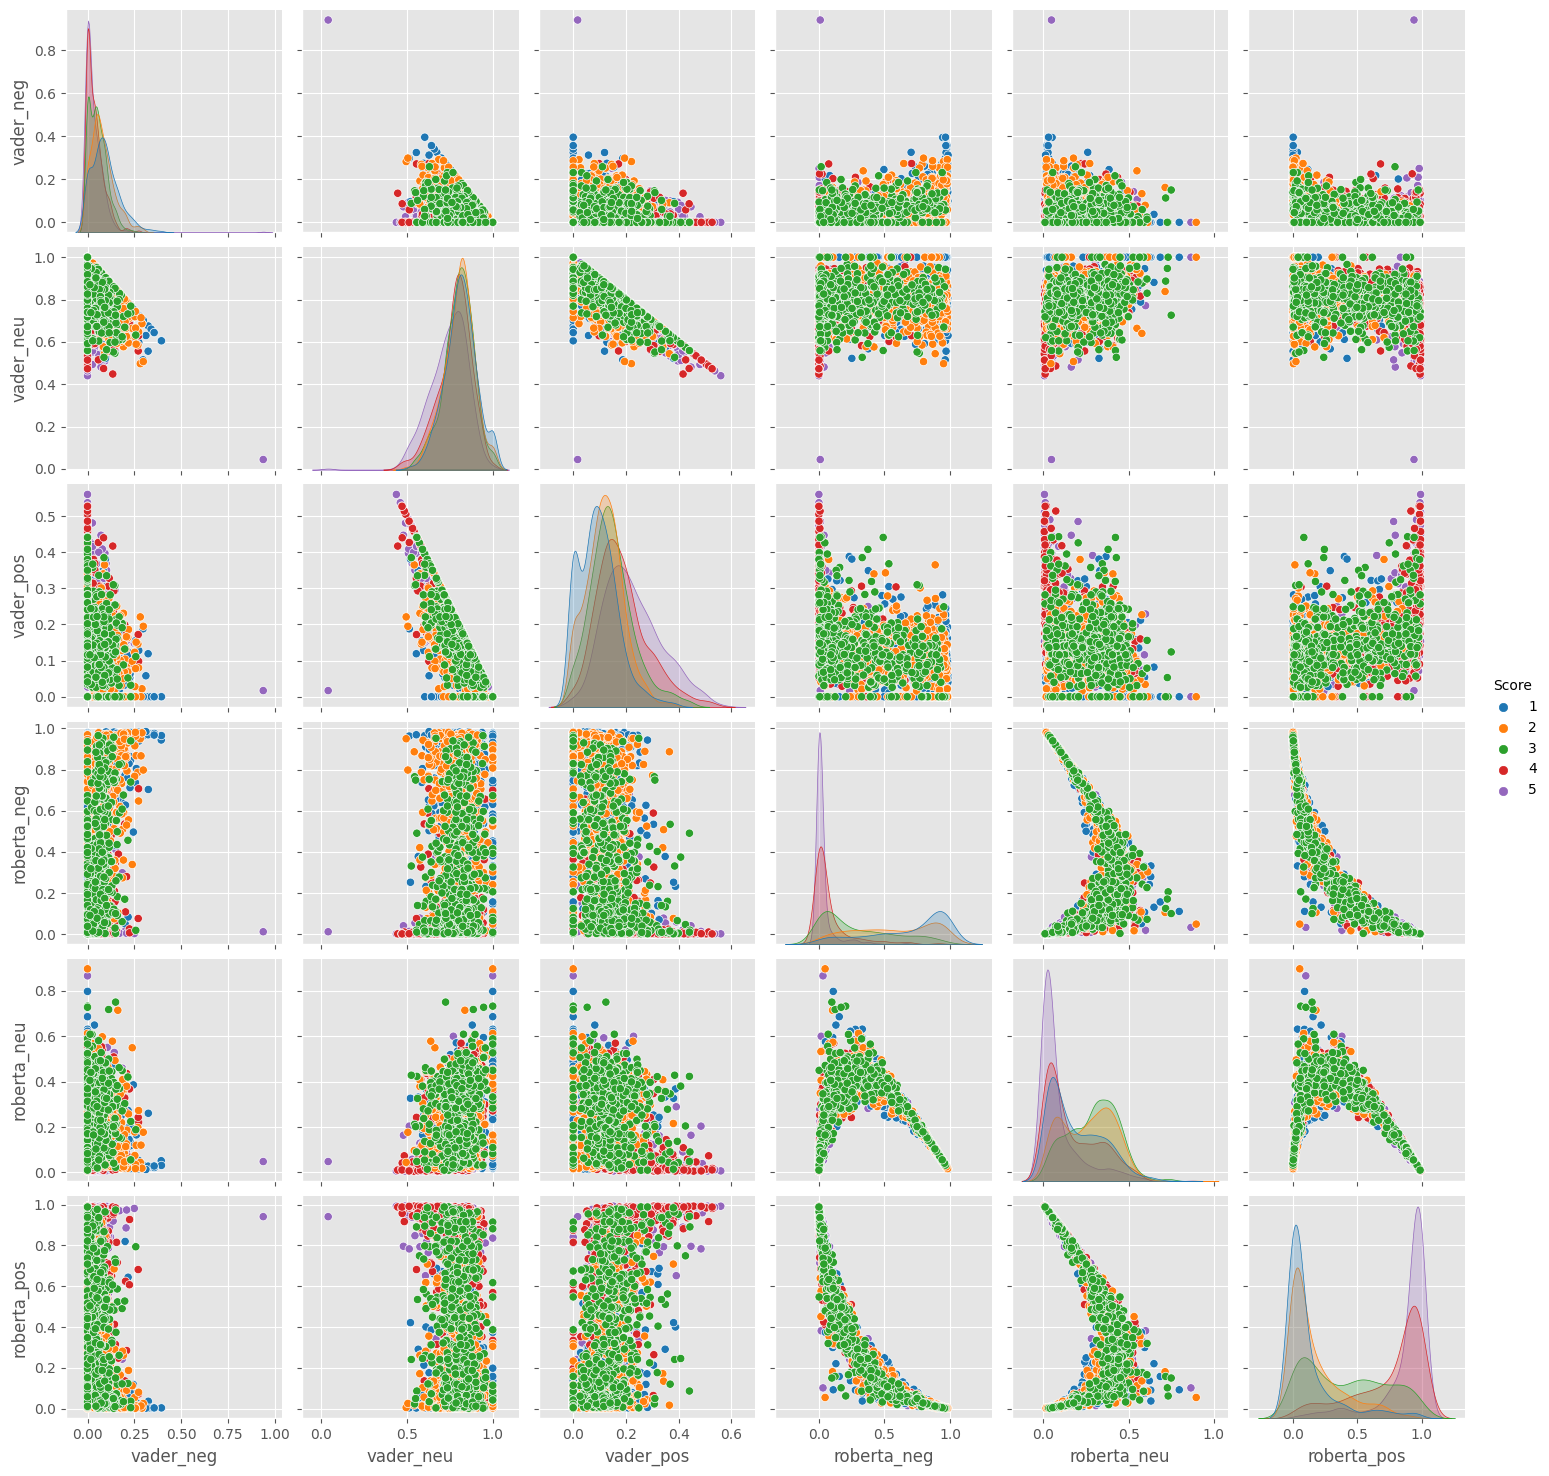

In [ ]:
sns.pairplot(data=final,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

# Review Examples (Errors)

* Positive 1-Star and Negative 5-Star Reviews

In [ ]:
final.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[1]

'I love SodaStream Zero and I love Pepsi Throwbacks (with pure cane sugar, when you can find them).  So I excited when I heard SodaStream was coming out with this flavor sweetened with cane sugar).<br /><br />This was the nastiest tasting flavor that I have had.  I hope SodaStream redoes this flavor.'

In [ ]:
final.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[3]

"I love Newman's products, but my dog hated it.  We purchased a case hoping to feed our dog something that doesn't contain all of the artificial chemicals, but he wanted nothing to do with it!  If you like organic, support Newman's products.  Hopefully your dog will like it better."

In [ ]:
final.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[1]

'My cat has been watching me suspiciously carefully and I think he is trying to work out how he can order cases and cases of these. I had better keep a careful eye on my credit card....'

In [ ]:
final.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[7]

'This is a nice dark red tea.  Not like most herbal teas which normally do not get very dark.  The flavor is very robust, as I said, almost like the cinnamon gum or cinnamon candies.  No need for milk, just use honey.  It is delicious, like having a dessert.'

# Model Applying on own examples

* Positive review on a Monitor from Flipkart

In [ ]:
sia.polarity_scores("Classy Monitor. Best In budget. Worthy for every penny spent.")

{'neg': 0.0, 'neu': 0.412, 'pos': 0.588, 'compound': 0.875}

* Positive review on a Printer from Flipkart

In [ ]:
sia.polarity_scores("Timely delivery. Print quality is excellent. Easy to install. Got it at the best price. As usual, happy with my shopping experience")

{'neg': 0.0, 'neu': 0.554, 'pos': 0.446, 'compound': 0.9382}

* Negative review on a tshirt in Flipkart

In [ ]:
polarity_scores_roberta("Money waste don't BUY this tshirt cheap quality product. Only image is good but the product is worst")

{'roberta_neg': 0.92367667,
 'roberta_neu': 0.064796746,
 'roberta_pos': 0.011526644}

* Positive feedback on a Chocolate in Flipkart

In [ ]:
polarity_scores_roberta("great packing . Resultant ice pack are there for which chocolate does not melt at all. Delivered in absolutely right condition ,Thanks Flipkart")

{'roberta_neg': 0.0028621084,
 'roberta_neu': 0.031150341,
 'roberta_pos': 0.96598756}

# Topic Modeling

In [ ]:
!pip install pyLDAvis==2.1.2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97721 sha256=35293f9ea48df56349d341da64221174c344c980875912b9ddd12de9ecadc07c
  Stored in directory: /root/.cache/pip/wheels/d9/93/d6/16c95da19c32f037fd75135ea152d0df37254c25cd1a8b4b6c
Successfully built pyLDAvis
  Attempting uninstall: pyLDAvis
    Found existing installation: pyLDAvis 3.4.1
    Uninstalling pyLDAvis-3.4.1:
      Successfully uninstalled pyLDAvis-3.4.1


In [ ]:
import gensim
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk import corpus
from gensim import corpora

In [ ]:
import pyLDAvis
import pyLDAvis.gensim

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
dataset.head()

,Id,Score,Summary,Text,Preprocessed_Text,key
0,156825,5,Good Stuff. Fair Price,"If you're a Crystal Light fan, this will not d...",if you 're a crystal light fan this will not d...,0
1,353928,5,I love this Quinoa. Cooks up well in a rice co...,This has quickly become a staple in our home! ...,this has quickly become a staple in our home i...,1
2,447975,5,Everyone said GREAT!,Unfortunately I never had a chance to try thes...,unfortunately i never had a chance to try thes...,2
3,447676,5,Pregnant 1 month after drinking,I drank this tea 3-4 cups everyday and the nex...,i drank this tea 3 4 cups everyday and the nex...,3
4,112409,5,Yum,"Bought these for my girlfriend, she loves them...",bought these for my girlfriend she loves them ...,4


In [ ]:
#Function to display the frequent words in the Preprocessed Text
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

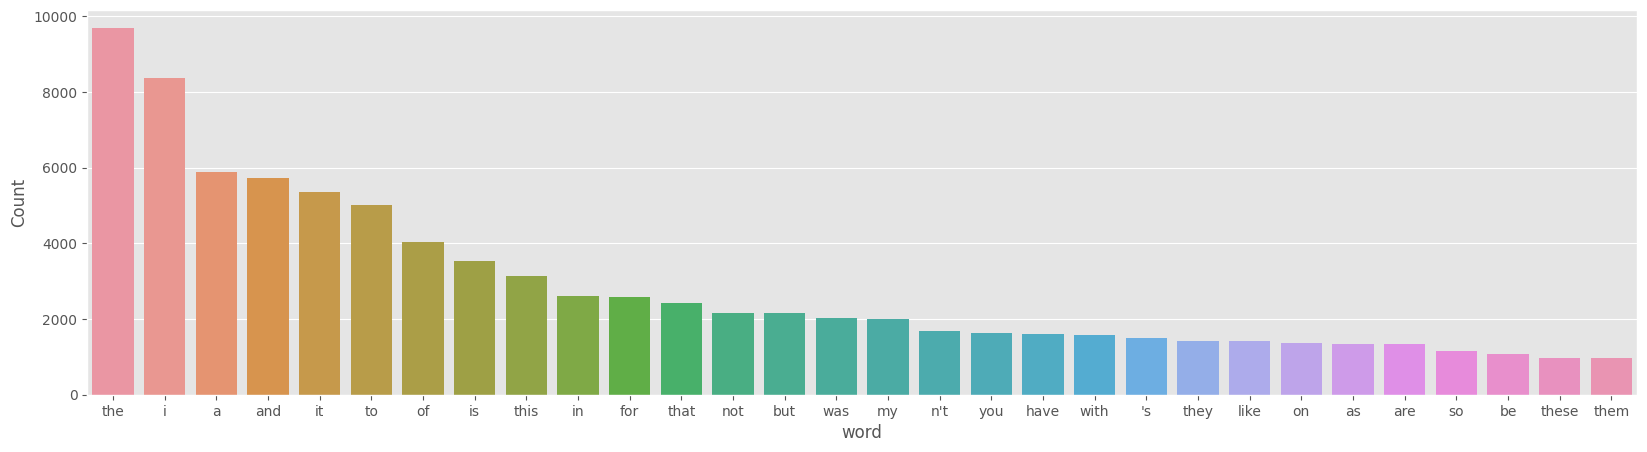

In [ ]:
freq_words(dataset['Preprocessed_Text'])

Most common words are ‘the’, ‘and’, ‘to’, so on and so forth. These words are not so important for our task and they do not tell any story. We’ have to get rid of these kinds of words. Before that let’s remove the punctuations and numbers from our text data.

In [ ]:
dataset['Preprocessed_Text'] = dataset['Preprocessed_Text'].str.replace("[^a-zA-Z#]", " ")

<ipython-input-254-35f61508d1e2>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset['Preprocessed_Text'] = dataset['Preprocessed_Text'].str.replace("[^a-zA-Z#]", " ")


In [ ]:
dataset.head()

,Id,Score,Summary,Text,Preprocessed_Text,key
0,156825,5,Good Stuff. Fair Price,"If you're a Crystal Light fan, this will not d...",if you re a crystal light fan this will not d...,0
1,353928,5,I love this Quinoa. Cooks up well in a rice co...,This has quickly become a staple in our home! ...,this has quickly become a staple in our home i...,1
2,447975,5,Everyone said GREAT!,Unfortunately I never had a chance to try thes...,unfortunately i never had a chance to try thes...,2
3,447676,5,Pregnant 1 month after drinking,I drank this tea 3-4 cups everyday and the nex...,i drank this tea cups everyday and the nex...,3
4,112409,5,Yum,"Bought these for my girlfriend, she loves them...",bought these for my girlfriend she loves them ...,4


### Let’s try to remove the stopwords and short words (<2 letters) from the reviews.

In [ ]:
stop_words = stopwords.words('english')

In [ ]:
#function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
dataset['Preprocessed_Text'] = dataset['Preprocessed_Text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in dataset['Preprocessed_Text']]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

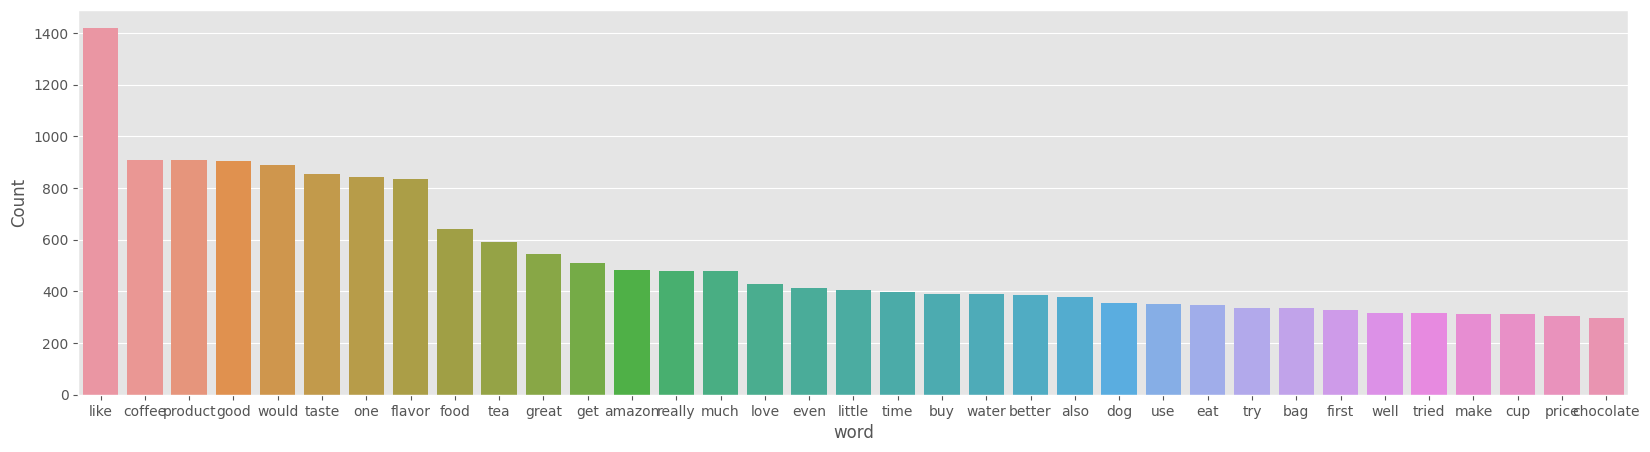

In [ ]:
freq_words(reviews, 35)

 Terms like 'coffee', 'product'& 'taste' have come up which are quite relevant for the Automotive category. However, we still have neutral terms(like, would, time etc).

### Lemmatization

In [ ]:
import spacy
nlp= spacy.load("en_core_web_sm")

In [ ]:
def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent))
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

In [ ]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['quickly', 'become', 'staple', 'home', 'pleasant', 'nutty', 'taste', 'nice', 'plain', 'seasoned', 'works', 'well', 'lot', 'foods', 'need', 'rinsed', 'cooks', 'easily', 'rice', 'cooker', 'love', 'get', 'started', 'one', 'hand', 'less', 'minute', 'baby', 'hip', 'one', 'time', 'made', 'measured', 'whole', 'package', 'rice', 'cooker', 'cup', 'rice', 'cooker', 'cups', 'added', 'twice', 'much', 'water', 'rice', 'cooker', 'cups', 'took', 'note', 'water', 'level', 'rice', 'cooker', 'bowl', 'right', 'sweet', 'line', 'dump', 'pouch', 'bowl', 'fill', 'water', 'sweet', 'line', 'set', 'brown', 'rice', 'setting', 'start', 'rice', 'cooker', 'brown', 'rice', 'setting', 'takes', 'minutes', 'start', 'early', 'day', 'rice', 'cooker', 'keeps', 'warm', 'ready', 'always', 'comes', 'light', 'fluffy', 'tried', 'quick', 'rice', 'setting', 'stove', 'top', 'honestly', 'sure', 'difference', 'taste', 'texture', 'methods', 'make', 'entire', 'package', 'twice', 'week', 'family', 'eats', 'first', 'night', 'finish', 

In [ ]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1])

['staple', 'home', 'pleasant', 'nutty', 'nice', 'work', 'lot', 'food', 'cook', 'rice', 'cooker', 'love', 'hand', 'minute', 'baby', 'hip', 'time', 'measured', 'whole', 'package', 'rice', 'cooker', 'cup', 'rice', 'cooker', 'cup', 'much', 'water', 'rice', 'cooker', 'cup', 'note', 'water', 'level', 'rice', 'cooker', 'bowl', 'right', 'sweet', 'line', 'dump', 'pouch', 'bowl', 'fill', 'water', 'sweet', 'line', 'brown', 'rice', 'start', 'rice', 'cooker', 'brown', 'rice', 'setting', 'minute', 'early', 'day', 'rice', 'cooker', 'warm', 'ready', 'quick', 'rice', 'stove', 'top', 'sure', 'difference', 'taste', 'texture', 'method', 'entire', 'package', 'twice', 'week', 'family', 'first', 'night', 'finish', 'leftover', 'next', 'day', 'favorite', 'way', 'quinoa', 'salad', 'cold', 'onion', 'bell', 'pepper', 'red', 'wine', 'texture', 'quinoa', 'salad', 'vinaigrette', 'taste', 'delight', 'price', 'subscribe', 'great', 'organic', 'fair', 'trade', 'need']


In [ ]:
len(reviews_2)

2500

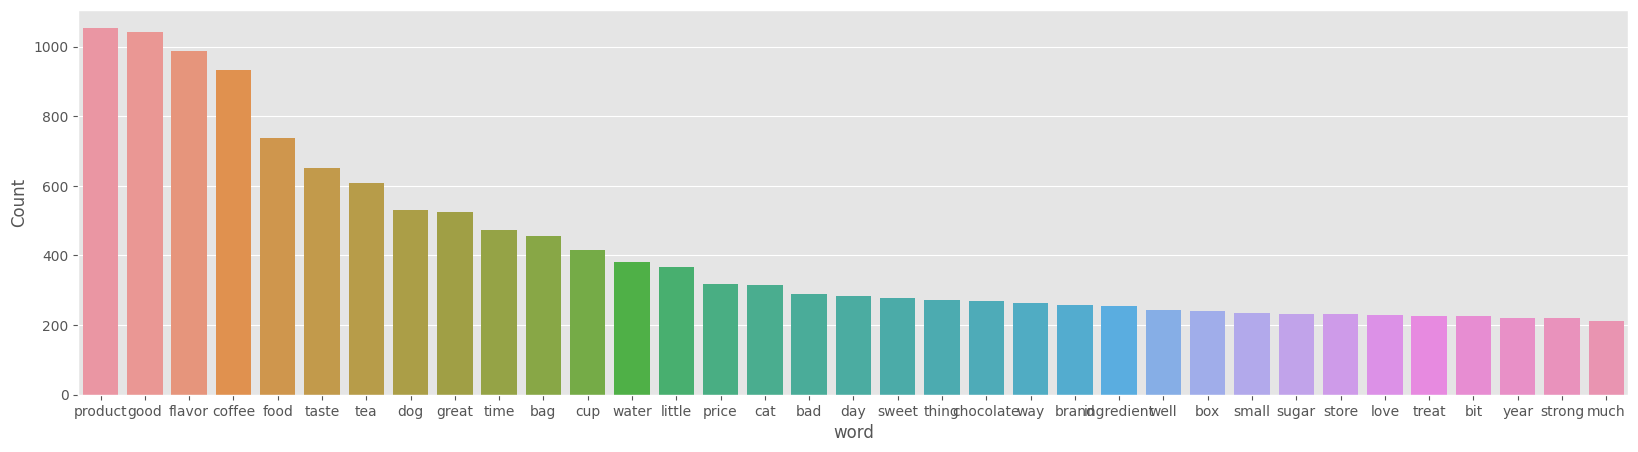

In [ ]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

dataset['Preprocessed_Text'] = reviews_3

freq_words(dataset['Preprocessed_Text'], 35)

### Building an LDA model

In [ ]:
dictionary = corpora.Dictionary(reviews_2)

In [ ]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [ ]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

In [ ]:
lda_model.print_topics()

[(0,
  '0.029*"dog" + 0.025*"bag" + 0.021*"product" + 0.019*"treat" + 0.013*"time" + 0.012*"great" + 0.010*"price" + 0.009*"store" + 0.008*"good" + 0.008*"small"'),
 (1,
  '0.030*"water" + 0.025*"product" + 0.018*"bottle" + 0.009*"noodle" + 0.008*"time" + 0.007*"drink" + 0.007*"chicken" + 0.007*"energy" + 0.007*"soup" + 0.006*"vitamin"'),
 (2,
  '0.047*"flavor" + 0.036*"good" + 0.020*"taste" + 0.018*"chip" + 0.010*"sauce" + 0.010*"product" + 0.010*"butter" + 0.010*"texture" + 0.008*"salt" + 0.008*"bit"'),
 (3,
  '0.066*"coffee" + 0.038*"tea" + 0.027*"cup" + 0.021*"flavor" + 0.018*"good" + 0.016*"taste" + 0.013*"strong" + 0.013*"product" + 0.011*"pod" + 0.010*"bag"'),
 (4,
  '0.074*"food" + 0.041*"cat" + 0.023*"dog" + 0.015*"product" + 0.013*"ingredient" + 0.009*"good" + 0.009*"meat" + 0.009*"brand" + 0.007*"corn" + 0.007*"diet"'),
 (5,
  '0.040*"cookie" + 0.025*"chocolate" + 0.022*"box" + 0.018*"product" + 0.015*"pack" + 0.015*"order" + 0.013*"package" + 0.012*"time" + 0.010*"amazon" +

In [ ]:
import pyLDAvis
import pyLDAvis.gensim

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


BrokenProcessPool: ignored